# Modelling ALL vs AML

In [17]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [11]:
# Load datasets
data = pd.read_csv("Dataset/data_set_ALL_AML_train.csv")
data_test = pd.read_csv("Dataset/data_set_ALL_AML_independent.csv")
data_cancer = pd.read_csv("Dataset/actual.csv")


In [12]:
# Clean Train Set

# Remove call columns
train_keepers = [col for col in data.columns if "call" not in col]
data = data[train_keepers]

# Transposing data
data_transpose = data.transpose().copy()
data_transpose = data_transpose.drop('Gene Description')
data_transpose.columns = data_transpose.iloc[0]
data_transpose = data_transpose.drop('Gene Accession Number')
data_transpose.index.name = 'patient_number'
data_transpose.reset_index(inplace=True)
data_transpose['patient_number']=data_transpose['patient_number'].astype(int)

# Merging the training data with cancer status, renaming our training set back to train_set
patient_cancer = pd.merge(data_transpose, data_cancer, left_on = 'patient_number', right_on = 'patient',
                          how = 'left')
patient_cancer= patient_cancer.drop(columns =['patient'])
train_set = patient_cancer.copy()

In [13]:
# Clean Test Set

# Remove call columns
test_keepers = [col for col in data_test.columns if "call" not in col]
data_test = data_test[test_keepers]

# Transposing the test set
data_transpose = data_test.transpose().copy()
data_transpose = data_transpose.drop('Gene Description')
data_transpose.columns = data_transpose.iloc[0]
data_transpose = data_transpose.drop('Gene Accession Number')
data_transpose.index.name = 'patient_number'
data_transpose.reset_index(inplace=True)
data_transpose['patient_number']=data_transpose['patient_number'].astype(int)

# Merging the training data with cancer status, renaming our training set back to train_set
patient_cancer = pd.merge(data_transpose, data_cancer, left_on = 'patient_number', right_on = 'patient',
                          how = 'left')
patient_cancer= patient_cancer.drop(columns =['patient'])
test_set = patient_cancer.copy()

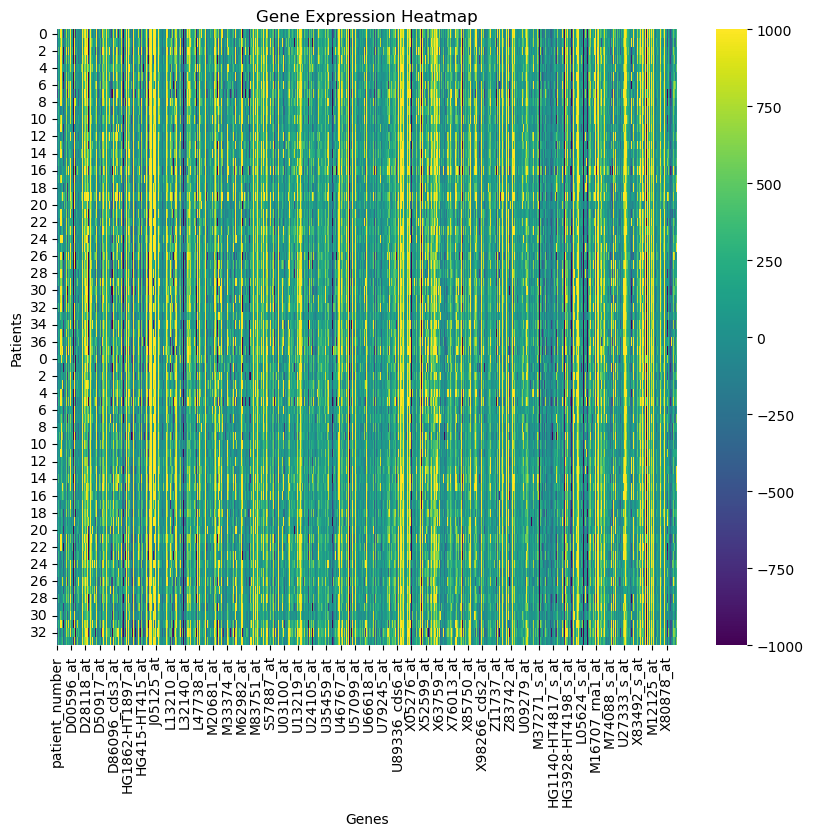

In [14]:
# Creating a df suitable for a heatmap
patients = pd.concat([train_set, test_set], axis=0) # Patients dataframe to include all 72 patients
patients.sort_values(by='cancer', ascending=True) # ALL will be top half, AML will be bottom half
patients = patients.drop(columns=['cancer']) # Dropping cancer col
patients = patients.apply(pd.to_numeric) # Ensuring numeric data

# Heatmap creation
plt.figure(figsize=(10, 8))
sns.heatmap(patients, cmap='viridis', vmin=-1000, vmax=1000)
plt.xlabel('Genes')
plt.ylabel('Patients')
plt.title('Gene Expression Heatmap')
plt.show()

In [15]:
# Dividing X and Y test and train
x_train = train_set.iloc[:, 1:-1]
y_train = train_set.iloc[:, -1]
x_test = test_set.iloc[:, 1:-1]
y_test = test_set.iloc[:, -1]

22 features explain around 90% of the variance. Only those principal components are needed to capture 90% of the information in the original dataset. From 7129 features to 22, not too bad.


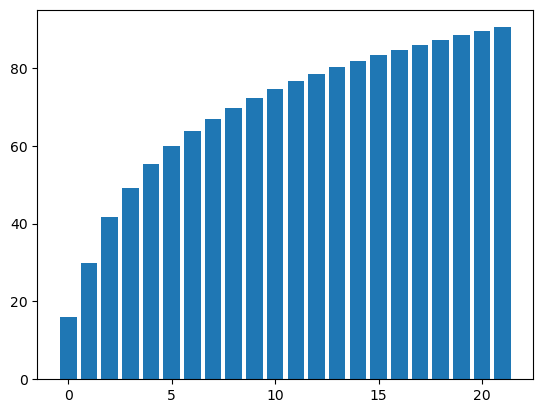

In [18]:
# PCA evaluation
pca = PCA()
pca.fit_transform(x_train)

total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " features explain around 90% of the variance. Only those principal components are needed to capture 90% of the information in the original dataset. From 7129 features to ", k, ", not too bad.", sep='')

pca = PCA(n_components=k)
x_train.pca = pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

In [22]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

# Extract features (genes) and labels
X_train = train_set.drop(columns=['patient_number', 'cancer'])
y_train = train_set['cancer']
X_test = test_set.drop(columns=['patient_number', 'cancer'])
y_test = test_set['cancer']

# Convert categorical labels ('ALL', 'AML') to numerical labels (0,1)
y_train_encoded = y_train.map({'ALL': 0, 'AML': 1})
y_test_encoded = y_test.map({'ALL': 0, 'AML': 1})

In [23]:
def compute_snr(X, y):
    class_0 = X[y == 0]
    class_1 = X[y == 1]
    mean_diff = abs(class_0.mean() - class_1.mean())
    std_sum = class_0.std() + class_1.std()
    snr = mean_diff / std_sum
    return snr.sort_values(ascending=False)

snr_scores = compute_snr(X_train, y_train_encoded)
top_snr_genes = snr_scores.index[:50]  # Selecting top 50 genes based on SNR
X_train_snr = X_train[top_snr_genes]
X_test_snr = X_test[top_snr_genes]

In [24]:
# 2. Correlation-Based Feature Selection (CBFS)
def compute_cbfs(X, y):
    corrs = X.corrwith(y, numeric_only=True)
    return corrs.abs().sort_values(ascending=False)

cbfs_scores = compute_cbfs(X_train, y_train_encoded)
top_cbfs_genes = cbfs_scores.index[:50]  # Selecting top 50 genes based on CBFS
X_train_cbfs = X_train[top_cbfs_genes]
X_test_cbfs = X_test[top_cbfs_genes]

In [25]:
# 3. Variance Threshold Method
var_thresh = VarianceThreshold(threshold=0.01)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)

In [26]:
# 4. Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_encoded)
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_rf_genes = feature_importances.nlargest(50).index  # Selecting top 50 genes
X_train_rf = X_train[top_rf_genes]
X_test_rf = X_test[top_rf_genes]




In [27]:
# Displaying selected features
print("Top 10 SNR Features:")
print(snr_scores.head(10))
print("\nTop 10 CBFS Features:")
print(cbfs_scores.head(10))
print("\nTop 10 RF Importance Features:")
print(feature_importances.nlargest(10))

Top 10 SNR Features:
M55150_at           1.467641
U50136_rna1_at      1.421708
X95735_at            1.40577
U22376_cds2_s_at    1.339308
M16038_at           1.202917
M23197_at           1.195974
M84526_at           1.191039
Y12670_at           1.184737
U82759_at            1.16416
D49950_at            1.13979
dtype: object

Top 10 CBFS Features:
Series([], dtype: float64)

Top 10 RF Importance Features:
M55150_at            0.027593
HG627-HT5097_s_at    0.023679
D88422_at            0.018972
U22376_cds2_s_at     0.018766
M23197_at            0.017642
X83490_s_at          0.017470
U62136_at            0.016984
M81933_at            0.016294
M21551_rna1_at       0.014957
U19878_at            0.013110
dtype: float64


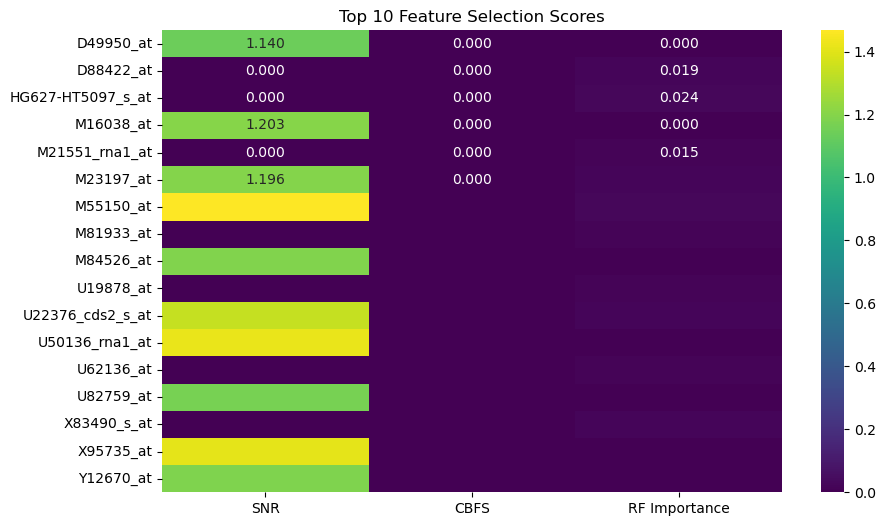

In [32]:
# Prepare DataFrame for heatmap
feature_scores_df = pd.DataFrame({
    "SNR": snr_scores.head(10),
    "CBFS": cbfs_scores.head(10),
    "RF Importance": feature_importances.nlargest(10)
})

# Drop any NaN values and ensure numeric data
feature_scores_df = feature_scores_df.fillna(0)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(feature_scores_df, annot=True, cmap="viridis", fmt=".3f")
plt.title("Top 10 Feature Selection Scores")
plt.show()
